In [33]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Path to your dataset in Google Drive
dataset_path = '/content/drive/MyDrive/Vehicles'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 44.9 MB/s eta 0:00:00


In [34]:
# Step 1: Import necessary libraries
import os
import cv2
import numpy as np
import pywt
import joblib
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from google.colab import files
from sklearn.metrics import classification_report
import tensorflow as tf
import random


In [35]:
# Step 2: Inspect the folder structure and dataset
import os

dataset_path = '/content/drive/MyDrive/Vehicles'

# List all subdirectories (vehicle classes)
subdirs = os.listdir(dataset_path)
print("Subdirectories (vehicle classes):", subdirs)

# Check how many images are there in each class
for subdir in subdirs:
    subdir_path = os.path.join(dataset_path, subdir)
    if os.path.isdir(subdir_path):
        num_images = len(os.listdir(subdir_path))
        print(f"Class: {subdir}, Number of Images: {num_images}")


Subdirectories (vehicle classes): ['Trains', 'Ships', 'Motorcycles', 'Auto Rickshaws', 'bicycle', 'Planes', 'Cars']
Class: Trains, Number of Images: 800
Class: Ships, Number of Images: 800
Class: Motorcycles, Number of Images: 800
Class: Auto Rickshaws, Number of Images: 800
Class: bicycle, Number of Images: 800
Class: Planes, Number of Images: 800
Class: Cars, Number of Images: 790


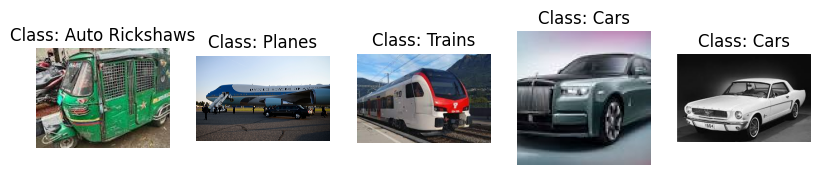

In [36]:


def display_random_images(dataset_path, num_samples=5):
    # Get all class labels (subdirectories)
    subdirs = os.listdir(dataset_path)

    plt.figure(figsize=(10, 10))

    for i in range(num_samples):
        # Randomly choose a class and an image from that class
        subdir = random.choice(subdirs)
        subdir_path = os.path.join(dataset_path, subdir)
        img_name = random.choice(os.listdir(subdir_path))
        img_path = os.path.join(subdir_path, img_name)

        # Load and display the image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(f"Class: {subdir}")
        plt.axis('off')

    plt.show()

# Display 5 random images
display_random_images(dataset_path)


In [37]:
# Step 3: Define the Wavelet Transformation function
def w2d(img, mode, level):
    # Convert the image to grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Perform Discrete Wavelet Transform (DWT)
    coeffs2 = pywt.dwt2(img_gray, mode)
    LL, (LH, HL, HH) = coeffs2

    # Flatten the coefficients and return them as a feature vector
    return np.concatenate([LL.flatten(), LH.flatten(), HL.flatten(), HH.flatten()])


In [38]:
# Step 4: Preprocess the image function
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(32, 32))  # Resize the image
    img_array = image.img_to_array(img)  # Convert to an array

    # Perform the Wavelet Transform
    img_har = w2d(img_array, 'db1', 5)

    # Resize the original image to match model input
    img_resized = cv2.resize(img_array, (32, 32))
    img_har_resized = img_har.reshape(32 * 32)  # Flatten the Wavelet output

    # Combine the original and wavelet features
    combined_img = np.concatenate([img_resized.flatten(), img_har_resized])
    return combined_img


In [39]:
# Step 5: Load the dataset and preprocess images
dataset_path = '/content/drive/MyDrive/Vehicles'

X = []  # Feature vector
y = []  # Labels

# Iterate through the dataset and preprocess each image
for subdir in os.listdir(dataset_path):
    subdir_path = os.path.join(dataset_path, subdir)
    if os.path.isdir(subdir_path):
        for img_name in os.listdir(subdir_path):
            img_path = os.path.join(subdir_path, img_name)
            img_array = preprocess_image(img_path)
            X.append(img_array)
            y.append(subdir)  # Use the subdirectory name as the label

X = np.array(X)
y = np.array(y)


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [40]:
# Step 6: Encode the labels to numerical values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


In [41]:
# Step 7: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


In [42]:
# Step 8: Train the model using Random Forest Classifier
best_clf = RandomForestClassifier(n_estimators=100, random_state=42)
best_clf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [43]:
# Step 9: Evaluate the model on test data
y_pred = best_clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.67      0.62      0.64       151
           1       0.54      0.46      0.49       144
           2       0.68      0.50      0.58       160
           3       0.76      0.78      0.77       173
           4       0.59      0.64      0.61       165
           5       0.55      0.66      0.60       181
           6       0.68      0.80      0.74       144

    accuracy                           0.64      1118
   macro avg       0.64      0.64      0.63      1118
weighted avg       0.64      0.64      0.64      1118



In [44]:
# Step 10: Save the trained model (optional)
joblib.dump(best_clf, 'best_model.pkl')


['best_model.pkl']

In [45]:
# Step 11: Load the trained model and predict using a new image
best_clf = joblib.load('best_model.pkl')

def predict_image(model, img_path):
    img_array = preprocess_image(img_path)
    img_array = img_array.reshape(1, -1)  # Reshape to match the model input format
    predictions = model.predict_proba(img_array)  # Get probabilities of each class

    # Print the raw prediction values
    print("Predictions (raw):", predictions)

    predicted_class = label_encoder.inverse_transform([np.argmax(predictions)])[0]
    confidence = round(100 * np.max(predictions), 2)

    return predicted_class, confidence


Saving Auto Rickshaw (52).JPG to Auto Rickshaw (52) (2).JPG
Saving Bike (11).jpg to Bike (11) (4).jpg
Saving Bike (771).jpg to Bike (771) (5).jpg
Saving Car (112).jpg to Car (112) (6).jpg
Saving Motorcycle (46).jpg to Motorcycle (46) (4).jpg
Saving Motorcycle (429).jpg to Motorcycle (429) (5).jpg
Predictions (raw): [[0.76 0.06 0.02 0.02 0.02 0.06 0.06]]
Predicted: Auto Rickshaws with confidence 76.0%


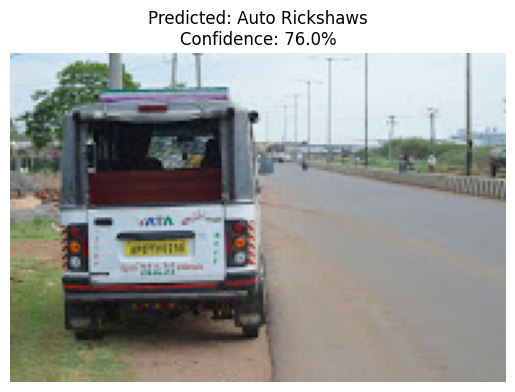

Predictions (raw): [[0.08 0.04 0.01 0.02 0.06 0.06 0.73]]
Predicted: bicycle with confidence 73.0%


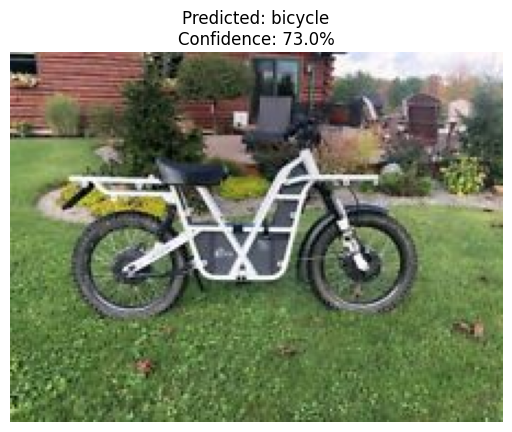

Predictions (raw): [[0.13 0.08 0.09 0.11 0.01 0.13 0.45]]
Predicted: bicycle with confidence 45.0%


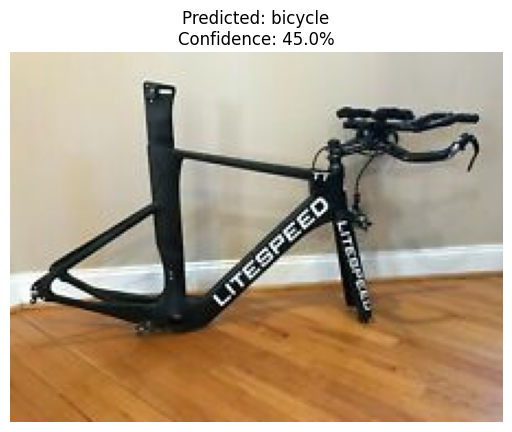

Predictions (raw): [[0.02 0.64 0.05 0.03 0.04 0.07 0.15]]
Predicted: Cars with confidence 64.0%


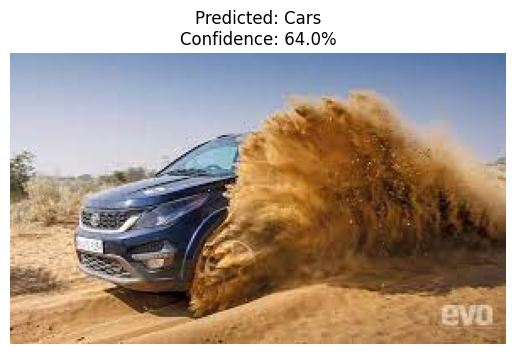

Predictions (raw): [[0.14 0.25 0.36 0.04 0.06 0.03 0.12]]
Predicted: Motorcycles with confidence 36.0%


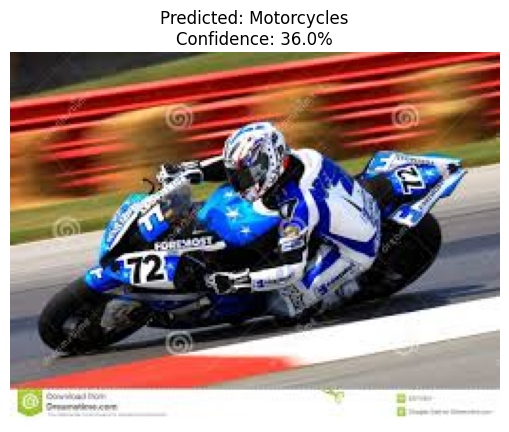

Predictions (raw): [[0.07 0.1  0.75 0.05 0.   0.02 0.01]]
Predicted: Motorcycles with confidence 75.0%


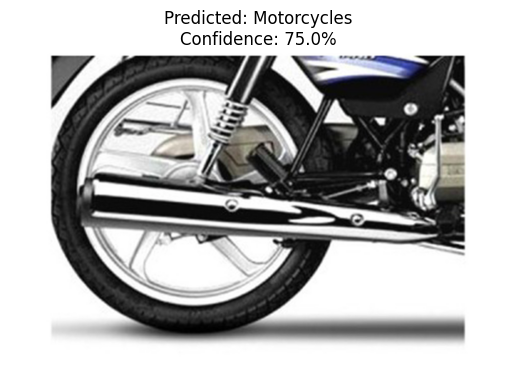

In [72]:
# Step 12: Upload a new image and make predictions
uploaded = files.upload()  # Upload a new image
for img_path in uploaded.keys():
    predicted_class, confidence = predict_image(best_clf, img_path)
    print(f"Predicted: {predicted_class} with confidence {confidence}%")

    # Display the image with prediction
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence}%")
    plt.axis('off')
    plt.show()
